# 1. Title: Wine Quality 

## 2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
## 3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  In the above reference, two datasets were created, using red and white wine samples.
  The inputs include objective tests (e.g. PH values) and the output is based on sensory data
  (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality 
  between 0 (very bad) and 10 (very excellent). Several data mining methods were applied to model
  these datasets under a regression approach. The support vector machine model achieved the
  best results. Several metrics were computed: MAD, confusion matrix for a fixed error tolerance (T),
  etc. Also, we plot the relative importances of the input variables (as measured by a sensitivity
  analysis procedure).
 
## 4. Relevant Information:

   The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables 
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods. 

## 5. Number of Instances: 
   red wine - 1599; white wine - 4898. 

## 6. Number of Attributes: 
   11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

## 7. Attribute information:

   For more information, read [Cortez et al., 2009].

   Input variables (based on physicochemical tests):
   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)

## 8. Missing Attribute Values: 
   None
   
# Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

In [2]:
import matplotlib.pyplot  as plt
import pandas as pds
import seaborn as sns
import math
import numpy as np
import sklearn as sk

In [3]:
white_db = pds.read_csv("winequality-white.csv", sep=";", header=0)
red_db = pds.read_csv("winequality-red.csv", sep=';', header=0)

In [4]:
print(white_db.shape)
print(red_db.shape)

(4898, 12)
(1599, 12)


In [5]:
white_db.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [21]:
red_db.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

In [7]:
white_db['color']='white'

In [14]:
white_db = white_db.drop('color', 1)

In [15]:
white_db.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [9]:
red_db['color']='red'

In [10]:
total_db=white_db.append(red_db, ignore_index=True)

In [11]:
total_db.shape[0]

6497

We have imported two databases one consisting of 4898 white wines and the other of 1599 red wines.  These databases each have 11 physical measurements with continous distributions and one integer rating catagory for the quality of the wine.

In [20]:
total_db['quality'].max(axis=0)

9

In [21]:
total_db['quality'].min(axis=0)

3

In [46]:
total_db['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

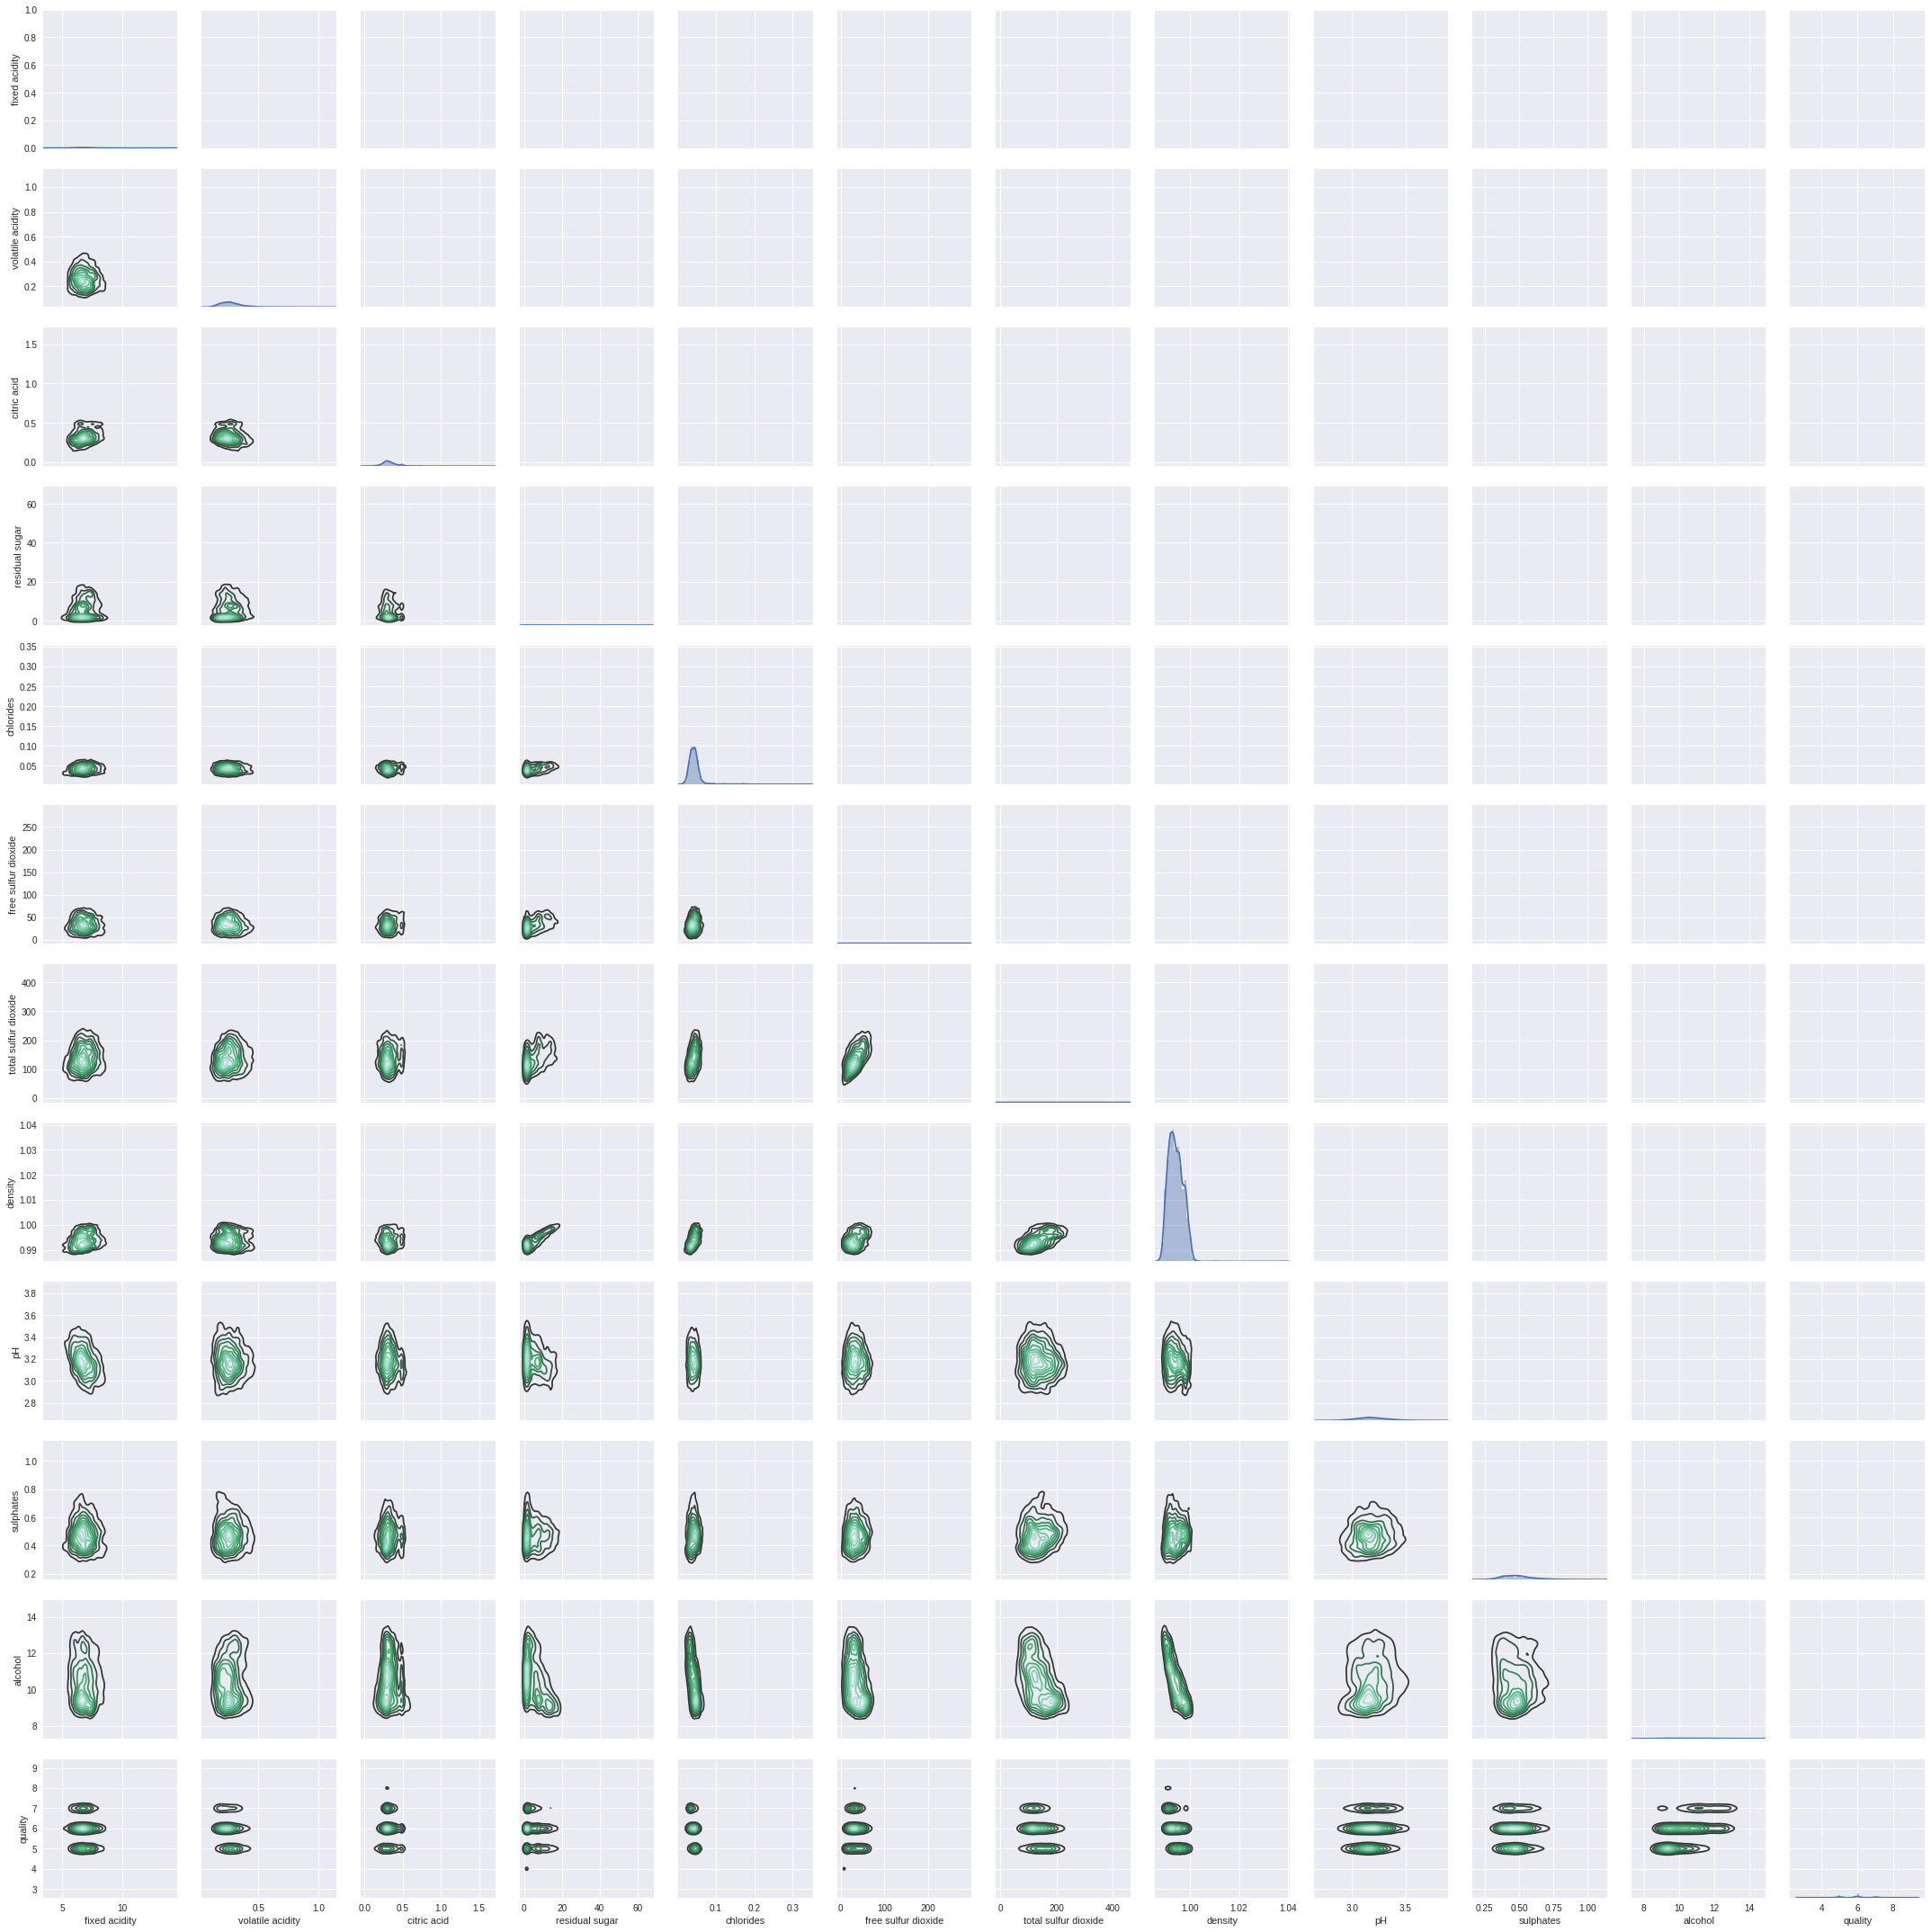

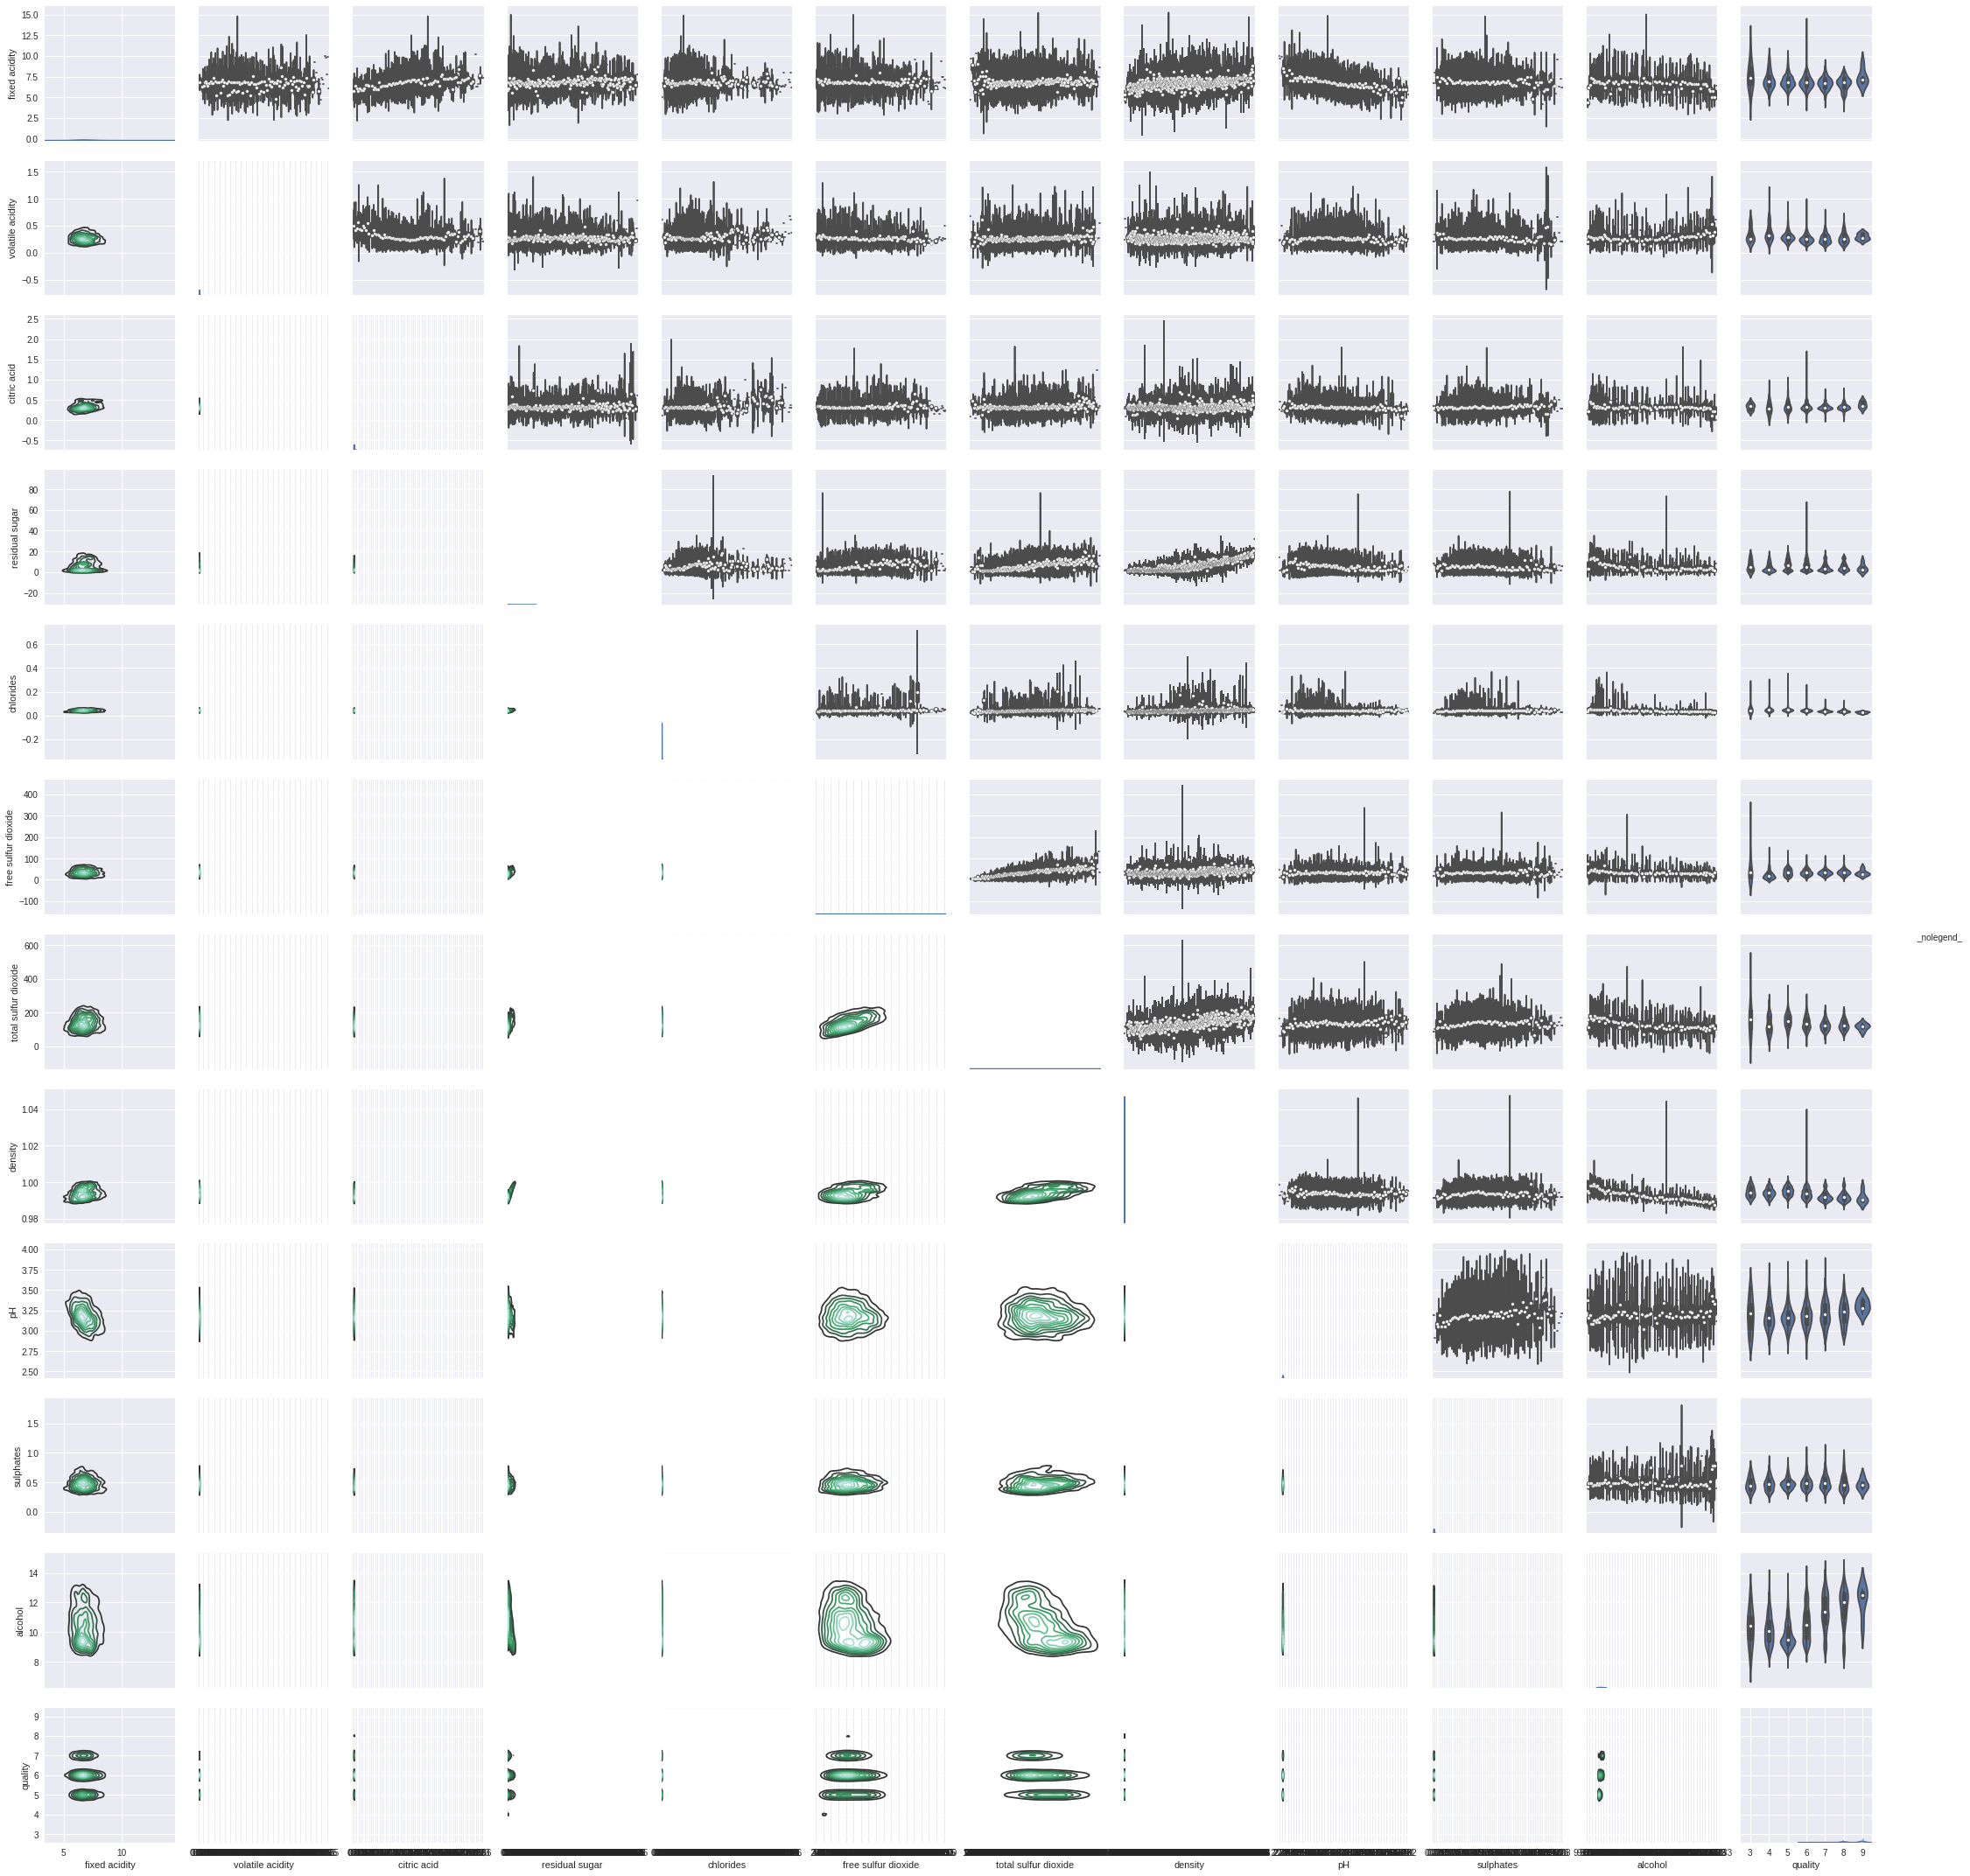

In [20]:
g = sns.PairGrid(white_db)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.violinplot)
g.add_legend()
plt.show()

In [ ]:
g = sns.PairGrid(red_db)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.violinplot)
g.add_legend()
plt.show()